# Evaluate PointCNN Classification on Modelnet40

In [2]:
import torch
from torch.utils.data import DataLoader
from custom_datasets import ModelNetPlyHDF52048DataLoader
from Models.pointcnn_v1 import PointCNNClassification_V1
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {torch.cuda.get_device_name(0) if device == 'cuda' else 'cpu'}")
print(f"Testing on {device}")


Using Tesla V100-PCIE-16GB
Testing on cuda


In [3]:
model_path = "exps/train6/best_model.pth"
pretrained = torch.load(model_path, map_location=torch.device(device))
print(pretrained.keys())

print("Pretrained for:", pretrained["epoch"])

model = PointCNNClassification_V1()
model.load_state_dict(pretrained["model_state_dict"])
model.to(device)

print()

dict_keys(['epoch', 'accuracy', 'class_accuracy', 'model_state_dict', 'optimizer_state_dict'])
Pretrained for: 94



In [4]:
# Load dataset
data_path = "data/modelnet40_ply_hdf5_2048"
test_dataset = ModelNetPlyHDF52048DataLoader(data_path, num_point=1024, split="test")
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Dataset length:", len(test_dataset))
print("DataLoader length:", len(test_dataloader))

Dataset length: 2468
DataLoader length: 78


Instance shape: (1024, 3)
Label shape: ()
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Batch sample length: 2
Sample class: bookshelf


Text(0.5, 0.92, 'Sample Point Cloud of a bookshelf object')

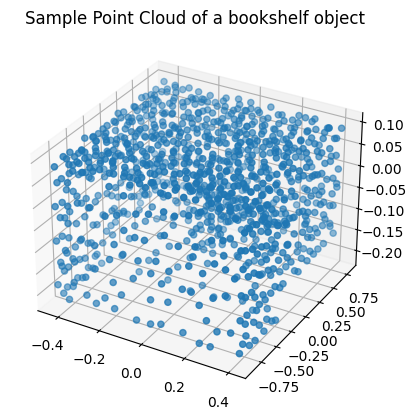

In [5]:
instance, label = test_dataset[0]
print("Instance shape:", instance.shape)
print("Label shape:", label.shape)

print(type(instance))
print(type(label))


# Take one sample from the dataloader
batch_sample = next(iter(test_dataloader))
print("Batch sample length:", len(batch_sample))

batch_sample_point_set = batch_sample[0]
batch_sample_label = batch_sample[1]

sample_point_set = batch_sample_point_set[0]
sample_label = batch_sample_label[0]
sample = sample_point_set.numpy()


idx_classes = test_dataset.idx_classes
cls = idx_classes[sample_label.item()]
print("Sample class: %s" % idx_classes[sample_label.item()])

X, Y, Z = sample[:, 0], sample[:, 1], sample[:, 2]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z)

plt.title(f"Sample Point Cloud of a {cls} object")

In [6]:
# Predict the class of the sample
model.eval()
with torch.inference_mode():
    points = sample_point_set.to(device)
    points = points.unsqueeze(0)
    output = model((points, points))
    pred_class = torch.argmax(output, dim=1).item()
        
print(f"Predicted class: {idx_classes[pred_class]}")

Predicted class: bookshelf


Now let's evaluate the overall accuracy on the test batch.

In [7]:
loader = test_dataloader

num_classes = len(idx_classes)
confusion_matrix = np.zeros((num_classes, num_classes))
print(confusion_matrix.shape)

model.eval()
with torch.inference_mode():
    correct = 0
    total = 0
    for batch_idx, (points, target) in tqdm(enumerate(loader), total=len(loader), smoothing=0.9):
        if device == "cuda":
            points, target = points.to(device), target.to(device)

        output = model((points, points))
        predicted = torch.argmax(output, dim=1)
        
        # print(target.shape, predicted.shape)
        
        # Update confusion matrix
        for i in range(len(target)):
            confusion_matrix[target[i]][predicted[i]] += 1
        
        correct += (predicted == target).sum().item()
        total += target.size(0)
        
      

        
    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}%")

(40, 40)


  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [00:22<00:00,  3.46it/s]

Accuracy: 76.99%


['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']


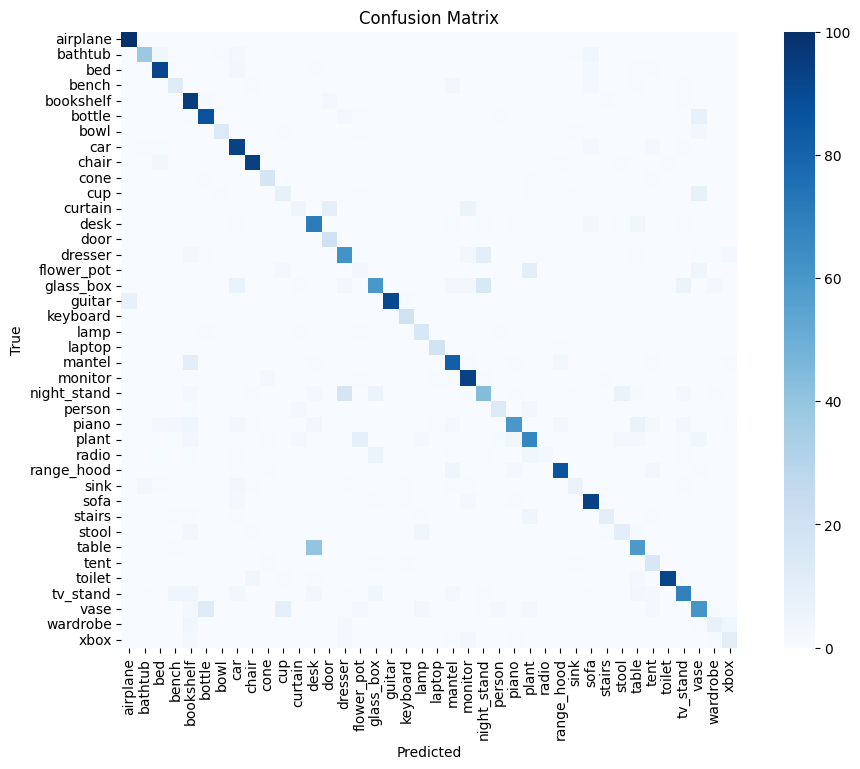

In [8]:
# Plot confusion matrix using seaborn
import seaborn as sns
import pandas as pd


plt.figure(figsize=(12, 8))
class_names = [idx_classes[i] for i in range(len(idx_classes))]
print(class_names)
sns.heatmap(confusion_matrix, cmap='Blues', square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("./images/output8.png")
plt.show()

